In [1]:
import sys
import torch
import os
import math
from os import makedirs
import numpy as np
import open3d as o3d
from random import randint
from scipy.spatial.transform import Rotation
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import random
import open3d as o3d

np.set_printoptions(suppress=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def getWorld2View(R, t):
    # Scannet R,t = C2W
    R_inv = R.T
    T_inv = -R_inv @ t

    world_to_camera = np.eye(4)
    world_to_camera[:3, :3] = R_inv
    world_to_camera[:3, 3] = T_inv

    return world_to_camera

In [3]:
def readFileMatrix(file_path):
    # Read the file
    with open(file_path, 'r') as file:
        lines = file.readlines()
    # Parse the matrix values
    matrix = []
    for line in lines:
        values = line.strip().split()
        row = [float(value) for value in values]
        matrix.append(row)

    # Convert the matrix to a numpy array
    matrix = np.array(matrix)
    return matrix

extrinsic_color = readFileMatrix('./intrinsic/extrinsic_color.txt')
extrinsic_depth = readFileMatrix('./intrinsic/extrinsic_depth.txt')
intrinsic_color = readFileMatrix('./intrinsic/intrinsic_color.txt')
intrinsic_depth = readFileMatrix('./intrinsic/intrinsic_depth.txt')

print('extrinsic_color:\n', extrinsic_color)
print('extrinsic_depth:\n', extrinsic_depth)
print('intrinsic_color:\n', intrinsic_color)
print('intrinsic_depth:\n', intrinsic_depth)


extrinsic_color:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
extrinsic_depth:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
intrinsic_color:
 [[1169.621094    0.        646.295044    0.      ]
 [   0.       1167.105103  489.927032    0.      ]
 [   0.          0.          1.          0.      ]
 [   0.          0.          0.          1.      ]]
intrinsic_depth:
 [[577.590698   0.       318.905426   0.      ]
 [  0.       578.729797 242.683609   0.      ]
 [  0.         0.         1.         0.      ]
 [  0.         0.         0.         1.      ]]


In [4]:
# Camera Extrinsics
directory = './pose/'
config_files = os.listdir(directory)

config_files = sorted(config_files, key=lambda x: int(x.split('.')[0]))

extrinsics = {}

for config_index in tqdm(range(len(config_files))):
# for config_index in tqdm(range(100)):
    file = config_files[config_index]
    frame_id = int(file.split('.')[0])
    config_file = os.path.join(directory, file)
    extrinsics[frame_id] = readFileMatrix(config_file)

100%|██████████| 5578/5578 [00:01<00:00, 2879.52it/s]


In [5]:
# Get the list of files in the directory
depth_files = os.listdir("./depth/")
color_files = os.listdir("./color/")

depth_files = sorted(depth_files, key=lambda x: int(x.split('.')[0]))
color_files = sorted(color_files, key=lambda x: int(x.split('.')[0]))

# Initialize an empty point cloud
point_cloud = o3d.geometry.PointCloud()

# depth_files = depth_files[:50]
# color_files = color_files[:50]

print("Number of files:", len(depth_files))

Number of files: 5578


In [6]:
# cx = intrinsic_depth[0][2]
# cy = intrinsic_depth[1][2]
# fx = intrinsic_depth[0][0]
# fy = intrinsic_depth[1][1]

cx = intrinsic_color[0][2]
cy = intrinsic_color[1][2]
fx = intrinsic_color[0][0]
fy = intrinsic_color[1][1]

depth_directory = "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\ScanNet\\scene0000_00\\sens_read\\depth"
color_directory = "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\ScanNet\\scene0000_00\\sens_read\\color"
ply_path = "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\ScanNet\\scene0000_00\\sens_read\\ply"

start_index = 0
# Limit for memory constraints
ply_len_limit = 150
frame_step = 10

In [7]:
def getFOVfromIntrsinicMatrix(intrinsic_matrix):
    # Extracting focal lengths and principal points
    f_x = intrinsic_matrix[0, 0]
    f_y = intrinsic_matrix[1, 1]
    c_x = intrinsic_matrix[0, 2]
    c_y = intrinsic_matrix[1, 2]

    # Calculating field of view
    fov_x = 2 * np.arctan2(c_x, f_x)
    fov_y = 2 * np.arctan2(c_y, f_y)

    # Converting radians to degrees
    fov_x_deg = np.degrees(fov_x)
    fov_y_deg = np.degrees(fov_y)

    return fov_x_deg, fov_y_deg


print(getFOVfromIntrsinicMatrix(intrinsic_color))
print(getFOVfromIntrsinicMatrix(intrinsic_depth))

rgb_values = cv2.calibrationMatrixValues(intrinsic_color[:3,:3],(1296, 968), apertureWidth=0, apertureHeight=0)
print('RGB:', rgb_values)

print('Depth:',cv2.calibrationMatrixValues(intrinsic_depth[:3,:3],(640, 480), apertureWidth=0, apertureHeight=0))

(57.84725953630014, 45.543350809813575)
(57.80885406175556, 45.50034761691183)
RGB: (57.975069145065966, 45.04680483450007, 1169.621094, (646.295044, 490.98319395148167), 0.9978488837001088)
Depth: (57.97501175787193, 45.04695360940006, 577.590698, (318.905426, 242.20594108353654), 1.001972156068206)


In [8]:
config_files = os.listdir("G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\ScanNet\\scene0000_00\\sens_read\\pose")
config_files.sort(key=lambda x: int(x.split('.')[0]))
config_files[:5]

['0.txt', '1.txt', '2.txt', '3.txt', '4.txt']

In [65]:
rgb_width, rgb_height = (1296, 968)
cx, cy, fx, fy , rgb_width, rgb_height

(646.295044, 489.927032, 1169.621094, 1167.105103, 1296, 968)

In [10]:
def getWorld2View4(R, t, translate=np.array([0.0, 0.0, 0.0]), scale=1.0):
    # Scannet R,t = C2W
    # Add Homogeneous Coordinate
    Rt = np.eye(4)
    Rt[:3, :3] = R
    Rt[:3, 3] = t

    # Add Translation and Scale
    C2W = Rt
    cam_center = C2W[:3, 3]
    cam_center = (cam_center + translate) * scale
    C2W[:3, 3] = cam_center

    # Invert
    R = C2W[:3, :3]
    t = C2W[:3, 3]
    R_inv = R.T
    T_inv = -R_inv @ t
    world_to_camera = np.eye(4)
    world_to_camera[:3, :3] = R_inv
    world_to_camera[:3, 3] = T_inv

    return np.float32(world_to_camera)

In [51]:
def getProjectionMatrix(znear, zfar, fovX, fovY):
    tanHalfFovY = np.tan((np.radians(fovY) / 2))
    tanHalfFovX = np.tan((np.radians(fovX) / 2))

    top = tanHalfFovY * znear
    bottom = -top
    right = tanHalfFovX * znear
    left = -right

    P = np.zeros((4, 4))

    z_sign = 1.0

    P[0, 0] = 2.0 * znear / (right - left)
    P[1, 1] = 2.0 * znear / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[3, 2] = z_sign
    P[2, 2] = z_sign * zfar / (zfar - znear)
    P[2, 3] = -(zfar * znear) / (zfar - znear)
    return P

def getProjectionMatrixTorch(znear, zfar, fovX, fovY):
    tanHalfFovY = math.tan((fovY / 2))
    tanHalfFovX = math.tan((fovX / 2))

    top = tanHalfFovY * znear
    bottom = -top
    right = tanHalfFovX * znear
    left = -right

    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * znear / (right - left)
    P[1, 1] = 2.0 * znear / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[3, 2] = z_sign
    P[2, 2] = z_sign * zfar / (zfar - znear)
    P[2, 3] = -(zfar * znear) / (zfar - znear)
    return P

def create_perspective_projection_matrix(fovX, fovY, znear, zfar):
    tan_half_fovx = np.tan(np.radians(fovX) / 2.0)
    tan_half_fovy = np.tan(np.radians(fovY) / 2.0)

    right = znear * tan_half_fovx
    left = -right
    top = znear * tan_half_fovy
    bottom = -top

    P = np.zeros((4, 4))
    P[0, 0] = (2.0 * znear) / (right - left)
    P[0, 3] = -znear * (right + left) / (right - left)

    P[1, 1] = (2.0 * znear) / (top - bottom)
    P[1, 3] = -znear * (top + bottom) / (top - bottom)
    
    P[2, 2] = -(zfar + znear) / (zfar - znear)
    P[2, 3] =  2 * zfar * znear / (znear - zfar)
    
    P[3, 2] = -1.0
    
    # P = np.array([
    #     [1 / tan_half_fovx, 0, 0, 0],
    #     [0, 1 / tan_half_fovy, 0, 0],
    #     [0, 0, -(zfar + znear) / (zfar - znear), -1],
    #     [0, 0, -2 * zfar * znear / (zfar - znear), 0]
    # ])
    
    # P = np.array([
    #     [1 / tan_half_fovx, 0, 0, 0],
    #     [0, 1 / tan_half_fovy, 0, 0],
    #     [(right + left) / (right - left), (top + bottom) / (top - bottom), - (zfar + znear) / (zfar - znear), -1],
    #     [0, 0, -2 * zfar * znear / (zfar - znear), 0]
    # ])

    return P


rgb_intrinsic = cv2.calibrationMatrixValues(intrinsic_color[:3,:3],(1296, 968), apertureWidth=0, apertureHeight=0)
hFov, vFov = rgb_intrinsic[0], rgb_intrinsic[1]
zfar = 100.0
znear = 0.01
fovX = hFov
fovY = vFov

projection = getProjectionMatrix(znear, zfar, fovX, fovY)
projection_torch = np.array(getProjectionMatrixTorch(znear, zfar, fovX, fovY))
projection_pers =  create_perspective_projection_matrix(fovX, fovY, znear, zfar)

print('fovX:', fovX)
print('fovY:', fovY)
print('projection:\n', projection)
print('projection:\n', projection_torch)
print('projection:\n', projection_pers)

# projection = projection_torch
# projection = projection_pers

fovX: 57.975069145065966
fovY: 45.04680483450007
projection:
 [[ 1.80497376  0.          0.          0.        ]
 [ 0.          2.41142724  0.          0.        ]
 [ 0.          0.          1.00010001 -0.010001  ]
 [ 0.          0.          1.          0.        ]]
projection:
 [[ 1.1559232  0.         0.         0.       ]
 [ 0.         1.6979411  0.         0.       ]
 [ 0.         0.         1.0001    -0.010001 ]
 [ 0.         0.         1.         0.       ]]
projection:
 [[ 1.80497376  0.          0.         -0.        ]
 [ 0.          2.41142724  0.         -0.        ]
 [ 0.          0.         -1.00020002 -0.020002  ]
 [ 0.          0.         -1.          0.        ]]


In [149]:
def getArrowMesh():
    arrow = o3d.geometry.TriangleMesh.create_arrow(cylinder_radius=0.1,
                                               cone_radius=0.20,
                                               cylinder_height=0.25,
                                               cone_height=0.1,
                                               resolution=20,
                                               cylinder_split=4,
                                               cone_split=1)
    arrow.compute_vertex_normals()
    arrow.paint_uniform_color([1, 0, 0])
    return arrow

def getSphereMesh():
    mesh_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.02,
                                                      resolution=100)
    mesh_sphere.compute_vertex_normals()
    mesh_sphere.paint_uniform_color([0.1, 0.1, 0.7])
    return mesh_sphere

def getTranslationMatrix(point):
    T = np.eye(4)
    T[:3, 3] = point
    return T

In [180]:
np.set_printoptions(suppress=True)
def getPCD(points, colors):
    # Extract the transformed X, Y, Z coordinates
    X = points[0, :]
    Y = points[1, :]
    Z = points[2, :]
    # Stack the global coordinates
    point_cloud_points = np.vstack((X, Y, Z)).T
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud_points)
    # Add color to the point cloud
    pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd

def getMinMax(points):
    # Extract the transformed X, Y, Z coordinates
    X = points[0, :]
    Y = points[1, :]
    Z = points[2, :]
    min_x = np.min(X)
    min_y = np.min(Y)
    min_z = np.min(Z)
    max_x = np.max(X)
    max_y = np.max(Y)
    max_z = np.max(Z)
    print('X:', min_x, max_x)
    print('Y:', min_y, max_y)
    print('Z:', min_z, max_z)
    # return min_x, min_y, min_z, max_x, max_y, max_z

def showRasterizedImage(u,v, colors):
    assert len(u) == len(v) == len(colors)
    image_size = (rgb_height, rgb_width, 3)
    raster = np.zeros(image_size, dtype=np.float32)

    # print(np.shape(u), np.shape(v), np.shape(colors), np.shape(raster))

    raster[v, u] = colors
    # Clip values to ensure they are in the valid range [0, 1]
    image = np.clip(raster, 0, 1)
    plt.imshow(raster)
    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

Frame ID: 0
Points Camera Init
Point 0: [ 0.10526742 -0.90924292  1.90012438  1.        ] [711 -68]
UV:
0 1242
0 915


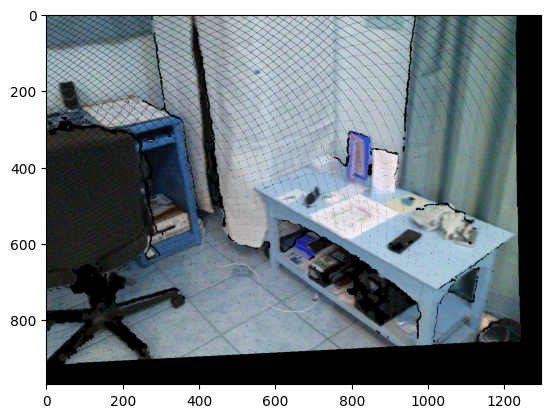

100%|██████████| 1/1 [00:06<00:00,  6.51s/it]


In [190]:
point_cloud = o3d.geometry.PointCloud()
Fpcd = None

arrows = []

# Using Numpy to create point clouds
# for i in tqdm(range(start_index, len(depth_files),frame_step)):
# for i in tqdm(range(start_index, ply_len_limit,frame_step)):
for i in tqdm(range(1)):
    depth_file_name = depth_files[i]
    color_file_name = color_files[i]

    depth_file = os.path.join(depth_directory, depth_file_name)
    color_file = os.path.join(color_directory, color_file_name)  

    frame_id = int(depth_file_name.split('.')[0])
    print('Frame ID:', frame_id)

    # Read the depth and color images
    color_image = cv2.imread(color_file)
    depth_image = cv2.imread(depth_file, cv2.IMREAD_UNCHANGED)
    target_resolution = (rgb_width, rgb_height)
    depth_image = cv2.resize(depth_image, target_resolution, interpolation=cv2.INTER_NEAREST)

    # Save the depth image as PNG
    cv2.imwrite(os.path.join('./', str(frame_id) + ".png"), depth_image)

    # color_image = cv2.resize(color_image, (640, 480), interpolation=cv2.INTER_NEAREST)

    # Convert images to numpy arrays
    depth_array = np.asarray(depth_image)
    color_array = np.asarray(color_image)
    
    width = color_array.shape[1]
    height = color_array.shape[0]

    assert frame_id in extrinsics, "No pose found for frame " + str(frame_id)

    pose = extrinsics[frame_id]

    # Convert depth to 3D coordinates in camera coordinates
    u, v = np.meshgrid(np.arange(width), np.arange(height))
    u = u.flatten()
    v = v.flatten()

    # print('Point Init Screen')
    # print(np.min(u), np.max(u))
    # print(np.min(v), np.max(v))

    # Convert depth to float32 for accurate calculations
    depth_image = depth_image.astype(np.float32)
    depth_scale = 1000.0
    depth = depth_image.flatten() / depth_scale # np.ones_like(depth_image.flatten())

    X = ((u - cx) * depth / fx)
    Y = ((v - cy) * depth / fy)
    Z = depth
    
    rgb_values = color_array.reshape((-1, 3)) / 255.0
    
    # Stack the 3D coordinates
    points_screen = np.vstack((u, v))
    points_camera = np.vstack((X, Y, Z, np.ones_like(X)))

    # Remove points with zero depth
    non_zero_mask = np.any(points_camera[:3,:] != 0, axis=0)
    points_camera = points_camera[:, non_zero_mask]
    rgb_values = rgb_values[non_zero_mask, :]
    points_screen = points_screen[:, non_zero_mask]
    
    # print('Points Camera Init')
    # point0 = points_camera[:, 0]
    # point0Screen = points_screen[:, 0]
    # print('Point 0:', point0, point0Screen)
    # getMinMax(points_camera)


    # Visualize Point Cloud in Camera Coordinates
    if False:
        pcd = getPCD(points_camera, rgb_values)
        point_cloud += pcd
        # pcd.transform([[1, 0, 0, 0],[0, -1, 0, 0],[0, 0, -1, 0],[0, 0, 0, 1]])
        # point_cloud += pcd

    # Transform to global coordinates
    points_global = np.dot(pose, points_camera)

    # Visualize Transform to camera coordinates again
    if True:
        # getMinMax(points_global)
        # print('Point Homogeneous')
        current_pose = extrinsics[10]
        R = current_pose[:3, :3]
        t = current_pose[:3, 3]
        W2C = getWorld2View4(R, t, translate=np.array([0.0, 0.0, 0.0]), scale=1.0)

        VP = np.dot(projection, W2C)

        points_camera_again = np.dot(W2C, points_global)

        # print('Point Camera Again')
        # print(np.shape(points_camera_again))
        # getMinMax(points_camera_again)

        point0 = points_camera_again[:, 0]

        X = points_camera_again[0, :]
        Y = points_camera_again[1, :]
        Z = points_camera_again[2, :]
        u = X * fx / Z + cx
        v = Y * fy / Z + cy

        u = u.astype(np.int64)
        v = v.astype(np.int64)

        valid_indices = np.where((u >= 0) & (u < rgb_width) & (v >= 0) & (v < rgb_height))
        u = u[valid_indices]
        v = v[valid_indices]
        # point0Screen = np.array([u[0], v[0]])
        # print('Point 0:', point0, point0Screen)
        # print('UV:')
        # print(np.min(u), np.max(u))
        # print(np.min(v), np.max(v))

        showRasterizedImage(u,v, rgb_values[valid_indices])
    
        # print(np.shape(points_camera_again))
        
        # print('Point NDC')
        # ndc_x = points_camera_again[0, :] / points_camera_again[3 , :]
        # ndc_y = points_camera_again[1, :] / points_camera_again[3 , :]
        # ndc_z = points_camera_again[2, :] / points_camera_again[3 , :]
        # getMinMax(np.vstack((ndc_x, ndc_y, ndc_z)).T)

        # print('NDC to Screen')
        # ndc_x = (ndc_x + 1) * width  / 2 # (ndc_x / w' + 1) * width / 2
        # ndc_y = (ndc_y + 1) * height / 2
        # ndc_z = ndc_z 
        # points_camera_again = np.vstack((ndc_x, ndc_y, ndc_z))
        # print('Point Screen Again')
        # print(np.shape(points_camera_again))
        # getMinMax(points_camera_again)
        

        pcd = getPCD(points_camera_again, rgb_values)
        point_cloud += pcd

    # Extract the transformed X, Y, Z coordinates
    X_global = points_global[0, :] / points_global[3 , :]
    Y_global = points_global[1, :] / points_global[3 , :]
    Z_global = points_global[2, :] / points_global[3 , :]
    
    # Stack the global coordinates
    point_cloud_global = np.vstack((X_global, Y_global, Z_global)).T
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud_global)
    pcd.colors = o3d.utility.Vector3dVector(rgb_values)
    # point_cloud += pcd

    # Flip the point cloud
    # pcd.transform([[1, 0, 0, 0],[0, -1, 0, 0],[0, 0, -1, 0],[0, 0, 0, 1]])
    # point_cloud += pcd

    # Save the point cloud to a file
    ply_file_path = os.path.join(ply_path, str(frame_id) + ".ply")    
    # o3d.io.write_point_cloud(ply_file_path, pcd)

    # Merge current point cloud with the overall point cloud
    # point_cloud += pcd

    # Clear memory
    # depth_image = None
    # color_image = None
    # depth_array = None
    # color_array = None
    # pcd = None


# Create an Open3D mesh representing coordinate axes
axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0, 0, 0])

# Create an Open3D mesh representing camera coordinate axes
arrow = getArrowMesh()
arrow.transform(pose)

sphere = getSphereMesh()
sphere.transform(getTranslationMatrix(point0[:3]))

# Visualize the final point cloud
geometry_list = [point_cloud, sphere] # axes, arrow
# o3d.visualization.draw_geometries(geometry_list)

point_cloud = None
axes = None
arrow = None

In [169]:
print(min(u), max(u))
print(min(v), max(v))

16 1288
20 962


In [ ]:
def projectPoint(u,v, depth):
    X = ((u - cx) * depth / fx) 
    Y = ((v - cy) * depth / fy)  
    Z = depth
    print(X, Y, Z)

projectPoint(0,0, depth[0])
# print(u[u.shape[0]-1], v[v.shape[0]-1])
# print(X[X.shape[0]-1], Y[Y.shape[0]-1])

In [ ]:
np.min(depth_array), np.max(depth_array)

In [ ]:
# Create a meshgrid
U, V = np.meshgrid(np.arange(10), np.arange(4))


print("U:\n", U)
print("V:\n", V)

# print(U[0],V[0])

print(U.flatten(),V.flatten())

In [ ]:
points_camera

In [ ]:
point_cloud_global

In [ ]:
p = np.array(Fpcd.points)

print(np.shape(p))
print(p[0],p[1254527] )

In [ ]:
# Project points in pcd using projection matrix FP in torch cuda and get result in NDC
points = torch.tensor(Fpcd.points, dtype=torch.float32, device='cuda')
colors = torch.tensor(Fpcd.colors, dtype=torch.float32, device='cuda')

In [ ]:
C2W = extrinsics[frame_id]

# Calculate projection matrix from camera to world
R = C2W[:3, :3]
t = C2W[:3, 3]
W2C = getWorld2View(R, t)
image_width, image_height = 1296, 968
# Normalized intrinsic parameters
fx_norm = 2 * fx / image_width
fy_norm = 2 * fy / image_height
cx_norm = (2 * cx - image_width) / image_width
cy_norm = (2 * cy - image_height) / image_height
zNear, zFar = 0.01, 100
# Projection matrix
P = np.array([
    [fx_norm, 0, cx_norm, 0],
    [0, fy_norm, cy_norm, 0],
    [0, 0, -(zFar + zNear) / (zFar - zNear), -2 * zFar * zNear / (zFar - zNear)],
    [0, 0, -1, 0]
])

FP = np.dot(P, W2C)
print(FP)

projection_matrix = torch.tensor(FP, dtype=torch.float32, device='cuda')


points_homogeneous = torch.cat((points, torch.ones(points.shape[0], 1, device=points.device)), dim=1)
projected_points_homogeneous = torch.matmul(points_homogeneous, projection_matrix.t()) # Clip space coordinates

print('Clip Space:', projected_points_homogeneous.shape, projected_points_homogeneous.min(), projected_points_homogeneous.max())

# # # Filter points outside clip space
# # mask = (projected_points_homogeneous[:, 0] >= -1) & (projected_points_homogeneous[:, 0] < 1) & \
# #        (projected_points_homogeneous[:, 1] >= -1) & (projected_points_homogeneous[:, 1] < 1 ) # & \
#        # (projected_points_homogeneous[:, 2] >= -1) & (projected_points_homogeneous[:, 2] < 1) // Removes points closer to camera so not included
# # projected_points_homogeneous = projected_points_homogeneous[mask]

# Clip Space / Homogenous to NDC
assert projected_points_homogeneous.shape[1] == 4
# Extract x, y, z, w from the tensor
x, y, z, w = projected_points_homogeneous[:, 0], projected_points_homogeneous[:, 1], projected_points_homogeneous[:, 2], projected_points_homogeneous[:, 3]
x_ndc = x / w
y_ndc = y / w
z_ndc = z / w
projected_points_NDC = torch.stack((x_ndc, y_ndc, z_ndc), dim=1)

print('NDC:', projected_points_NDC.shape, projected_points_NDC.min(), projected_points_NDC.max())

# # NDC to Image Space [-1,1] to [0,1]
# projected_points_IS = (projected_points_NDC + 1) / 2

# # Filter points outside image space
# mask = (projected_points_IS[:, 0] >= 0) & (projected_points_IS[:, 0] < 1) & \
#        (projected_points_IS[:, 1] >= 0) & (projected_points_IS[:, 1] < 1 ) # & \
#        # (projected_points_IS[:, 2] >= 0) & (projected_points_IS[:, 2] < 1)
# # projected_points_IS = projected_points_IS[mask]
# # points_filtered = points[mask]
# # colors_filtered = colors[mask]

# # print(projected_points_IS.shape, projected_points_IS.min(), projected_points_IS.max())

# # Get image width and height
# img_width, img_height = viewpoint_cam.image_width, viewpoint_cam.image_height
# # Calculate effective pixel width and height based on the sub-pixel variable
# effective_pixel_width, effective_pixel_height = img_width // sub_pixel_level, img_height // sub_pixel_level
# # Get pixel coordinates
# pixel_coordinates = projected_points_IS[:,:2] * torch.tensor([effective_pixel_width, effective_pixel_height], device=points.device).float()
# pixel_indices = torch.floor(pixel_coordinates).to(torch.int)


# # Create an empty image for visualization
# img = torch.zeros((968, 1296, 3), dtype=torch.uint8, device=points.device)
# pixel_indices_long = pixel_indices.to(torch.long)
# pixel_indices_long = torch.clamp(pixel_indices_long, 0, img_width - 1)
# pixel_indices_long = torch.cat((pixel_indices_long[:, 1:], pixel_indices_long[:, :1]), dim=1)  # Swap x and y for indexing
# colors_uint8 = (colors * 255).to(torch.uint8)
# img[pixel_indices_long[:, 1], pixel_indices_long[:, 0]] = colors_uint8
# img_cpu = img.cpu().detach().numpy()
# plt.imshow(img_cpu.astype(int))  # Convert the image to int for display
# plt.show()

In [ ]:
uv0 = np.array(Fpcd.points[0])
FP = np.array(FP)

np.dot(FP, np.append(uv0, 1))

In [ ]:
array = [[-1.72379681, 0.53521082, 0.00180556, 2.9798566],
         [0.28513336, 0.92574068, -2.20829687, -0.49507123],
         [0.26998599, 0.87311361, 0.40642428, -3.89656445],
         [0.269932, 0.872939, 0.406343, -3.87578721]]

tensor = torch.tensor(array).float()
print(type(tensor))  

In [ ]:
tensor.t()